In [2]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict

import json
import cv2
import copy as cp
import math
from PIL import Image
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import pickle
import random
import multi_loss_model as mlmodel

## Load train and test data

In [3]:
datapath = '../../../pedestrianDepth-baseline/MonoDepth-PyTorch/data/test/image_2/image_02/data/'

In [4]:
with open('train_data_ours_kitti.pickle', 'rb') as handle:
    train_data = pickle.load(handle)

In [5]:
with open('val_data_ours_kitti.pickle', 'rb') as handle:
    test_data = pickle.load(handle)

In [6]:
for person in train_data:
    person['keypoints'] = np.array(person['keypoints']).reshape(17,2)
for person in test_data:
    person['keypoints'] = np.array(person['keypoints']).reshape(17,2)

In [7]:
torch.cuda.is_available()

True

In [8]:
if torch.cuda.device_count()>1:
    #torch.cuda.device(1)
    torch.cuda.set_device(0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device="cpu"

In [9]:
print(torch.cuda.current_device())

0


In [10]:
def fix_orientation(angle):
    if angle<0:
        return 360+angle
    if angle>360:
        return angle-360
    else:
        return angle

In [11]:
for data in train_data:
    data['gt_orient']=fix_orientation(data['gt_orient'])
for data in test_data:
    data['gt_orient']=fix_orientation(data['gt_orient'])

In [12]:
random.shuffle(train_data)
random.shuffle(test_data)

In [13]:
def find_inputs_labels(pedestrians):
    inputs=[]

    angles=[]
    sin_cos=[]
    dimensions=[]
    positions=[]
    
    for pedestrian in pedestrians:
        angle=pedestrian['gt_orient']
        angles.append(angle)
        angle=angle*math.pi/180
        inputs.append(pedestrian['keypoints'].flatten())
        sin_cos.append([math.sin(angle),math.cos(angle)])
        dimensions.append(pedestrian['gt_dim'])
        positions.append(pedestrian['gt_pos'])
    inputs=np.array(inputs)
    sin_cos=np.array(sin_cos)
    angles=np.array(angles)
    dimensions=np.array(dimensions)
    positions=np.array(positions)
    return inputs, angles, sin_cos, dimensions, positions

In [14]:
[train_inputs, train_angles, train_sin_cos, train_dim, train_pos] = find_inputs_labels(train_data)
[test_inputs, test_angles, test_sin_cos, test_dim, test_pos] = find_inputs_labels(test_data)

In [15]:
print('train shape:',train_inputs.shape, train_angles.shape, train_sin_cos.shape, train_dim.shape, train_pos.shape)
print('test shape:',test_inputs.shape, test_angles.shape, test_sin_cos.shape, test_dim.shape, test_pos.shape)

train shape: (1584, 34) (1584,) (1584, 2) (1584, 3) (1584, 3)
test shape: (1663, 34) (1663,) (1663, 2) (1663, 3) (1663, 3)


## Define model and preprocess

In [16]:
net = mlmodel.LinearModel(34, 8)
net=net.to(device)

In [17]:
def convert_sin2angle(data):
    angles=[]
    for angle in data:
        angles.append(math.atan2(angle[0],angle[1])*180/math.pi)
    return np.array(angles)

In [18]:
def infer(inputs, model):
    inputs = torch.from_numpy(inputs).float().to(device)
    outputs = model(inputs)
    [orientations, dimensions, positions] = (outputs[:,:2], outputs[:,2:5],
                                             outputs[:,5:8])
    [orientations, dimensions, positions] = (orientations.cpu().detach().numpy(),
                                                      dimensions.cpu().detach().numpy(),
                                                      positions.cpu().detach().numpy())
    orientations = convert_sin2angle(orientations)
    orientations = np.array(list(map(fix_orientation, orientations)))
    
    return orientations, dimensions, positions

In [19]:
def find_losses(inputs, gt_angles, gt_dimensions, gt_positions, model):
    
    inputs=torch.from_numpy(inputs).float().to(device)
    outputs = model(inputs)
    [orientations, dimensions, positions] = (outputs[:,:2], outputs[:,2:5],
                                             outputs[:,5:8])
    [orientations, dimensions, positions] = (orientations.cpu().detach().numpy(),
                                                      dimensions.cpu().detach().numpy(),
                                                      positions.cpu().detach().numpy())
    
    orientations = convert_sin2angle(orientations)
    pred_angles = []
    for angle in orientations:
        pred_angles.append(fix_orientation(angle))
    pred_angles = np.array(pred_angles)
    angle_loss = abs(gt_angles-pred_angles)
    angle_loss = np.array(list(map(lambda x: x if x < 180 else 360-x, angle_loss)))
    
    dim_loss = np.linalg.norm(gt_dimensions - dimensions, axis=1)
    
    pos_loss = np.linalg.norm(gt_positions - positions, axis=1)
    
    return pred_angles, angle_loss, dim_loss, pos_loss

In [20]:
class PrepareData(Dataset):

    def __init__(self, X, orientations, dimensions, positions):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).float()
        
        if not torch.is_tensor(orientations):
            self.orientations = torch.from_numpy(orientations).float()
        
        if not torch.is_tensor(dimensions):
            self.dimensions = torch.from_numpy(dimensions).float()
        
        if not torch.is_tensor(positions):
            self.positions = torch.from_numpy(positions).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.orientations[idx], self.dimensions[idx], self.positions[idx]

In [21]:
sin_cos_LossFunc = nn.L1Loss()
dim_LossFunc = nn.MSELoss()
pos_LossFunc = nn.MSELoss()

In [22]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 100.0
    lrate = initial_lrate * math.pow(drop,
                                     math.floor((1+epoch)/epochs_drop))
    return lrate

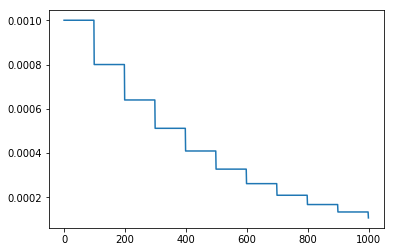

In [23]:
plt.plot(list(map(step_decay, range(1000))))

In [24]:
size_batches=100
ds = PrepareData(X=train_inputs, orientations=train_sin_cos, dimensions=train_dim,
                 positions=train_pos)

ds = DataLoader(ds, batch_size=size_batches, shuffle=True)

train_losses = {'angle loss':[], 'dim loss':[], 'pos loss':[]}
test_losses = {'angle loss':[], 'dim loss':[], 'pos loss':[]}
l1, l2, l3 = [], [], []

In [29]:
print(np.mean(find_losses(test_inputs, test_angles, test_dim, test_pos, net), axis=1))

[180.89617787  36.50341784   0.29959429   1.99112773]


## Train

In [26]:
p1, p2, p3 = 1, 12, 0.045

In [27]:
for epoch in range(500):  # loop over the dataset multiple times
    optimizer = optim.Adam(net.parameters(), lr=step_decay(epoch))
    for i, data in enumerate(ds, 0):
        # get the inputs
        batch_inputs, batch_orient, batch_dim, batch_pos = data
        (batch_inputs, batch_orient, batch_dim, batch_pos) = (batch_inputs.to(device), 
                                                                    batch_orient.to(device),
                                                                    batch_dim.to(device),
                                                                    batch_pos.to(device))

        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        # forward + backward + optimize
        batch_outputs = net(batch_inputs)
        out_orient, out_dim, out_pos = batch_outputs[:,:2], batch_outputs[:,2:5], batch_outputs[:,5:8]
        
        l_orient = sin_cos_LossFunc(out_orient, batch_orient)
        l_dim = dim_LossFunc(out_dim, batch_dim)
        l_pos = pos_LossFunc(out_pos, batch_pos)
        
        l1.append(l_orient)
        l2.append(l_dim)
        l3.append(l_pos)
        
        loss = p1*l_orient + p2*l_dim + p3*l_pos
        loss.backward()
        optimizer.step()
    #print(find_loss(train_inputs, train_gts, net))
    
    train_loss = find_losses(train_inputs, train_angles, train_dim, train_pos, net)
    train_losses['angle loss'].append(np.mean(train_loss[1]))
    train_losses['dim loss'].append(np.mean(train_loss[2]))
    train_losses['pos loss'].append(np.mean(train_loss[3]))
    
    test_loss = find_losses(test_inputs, test_angles, test_dim, test_pos, net)
    test_losses['angle loss'].append(np.mean(test_loss[1]))
    test_losses['dim loss'].append(np.mean(test_loss[2]))
    test_losses['pos loss'].append(np.mean(test_loss[3]))
    
    print(epoch,
          '\t train loss',
          round(np.mean(train_loss[1]),2),
          round(np.mean(train_loss[2]),2),
          round(np.mean(train_loss[3]),2),
          '\t test loss',
          round(np.mean(test_loss[1]),2),
          round(np.mean(test_loss[2]),2),
          round(np.mean(test_loss[3]),2))
    
    
print('Finished Training')

0 	 train loss 73.04 0.62 12.94 	 test loss 93.43 0.64 11.44
1 	 train loss 71.24 0.47 8.85 	 test loss 82.8 0.5 8.06
2 	 train loss 63.05 0.45 5.25 	 test loss 84.66 0.46 4.84
3 	 train loss 60.49 0.4 3.58 	 test loss 74.65 0.43 4.08
4 	 train loss 57.55 0.39 3.0 	 test loss 75.23 0.39 3.55
5 	 train loss 50.97 0.38 2.61 	 test loss 63.89 0.39 3.16
6 	 train loss 44.83 0.36 2.56 	 test loss 52.32 0.4 2.72
7 	 train loss 46.76 0.32 2.6 	 test loss 47.8 0.35 2.9
8 	 train loss 40.76 0.35 2.42 	 test loss 51.25 0.4 2.81
9 	 train loss 38.54 0.32 2.39 	 test loss 48.79 0.34 2.96
10 	 train loss 39.44 0.32 2.21 	 test loss 52.47 0.37 2.76
11 	 train loss 37.11 0.29 2.2 	 test loss 47.61 0.33 2.59
12 	 train loss 36.0 0.29 2.31 	 test loss 51.58 0.34 2.72
13 	 train loss 37.46 0.28 2.18 	 test loss 52.12 0.33 2.69
14 	 train loss 35.24 0.29 2.18 	 test loss 43.44 0.35 2.71
15 	 train loss 33.47 0.27 2.28 	 test loss 44.38 0.33 2.58
16 	 train loss 32.19 0.29 1.96 	 test loss 45.14 0.37 2.65

139 	 train loss 19.84 0.18 1.74 	 test loss 37.36 0.3 2.34
140 	 train loss 19.92 0.18 1.5 	 test loss 35.53 0.28 2.27
141 	 train loss 20.16 0.18 1.49 	 test loss 36.71 0.29 2.28
142 	 train loss 20.58 0.19 1.53 	 test loss 37.77 0.3 2.43
143 	 train loss 20.38 0.18 1.49 	 test loss 38.03 0.28 2.38
144 	 train loss 19.99 0.19 1.48 	 test loss 37.06 0.27 2.27
145 	 train loss 20.88 0.18 1.46 	 test loss 36.66 0.28 2.41
146 	 train loss 20.22 0.19 1.55 	 test loss 37.73 0.3 2.31
147 	 train loss 19.73 0.18 1.54 	 test loss 36.88 0.29 2.24
148 	 train loss 19.2 0.19 1.5 	 test loss 35.82 0.29 2.47
149 	 train loss 19.81 0.19 1.52 	 test loss 36.9 0.28 2.11
150 	 train loss 19.84 0.18 1.47 	 test loss 37.27 0.29 2.4
151 	 train loss 19.85 0.2 1.51 	 test loss 37.91 0.32 2.38
152 	 train loss 20.13 0.18 1.42 	 test loss 38.41 0.28 2.36
153 	 train loss 20.46 0.2 1.51 	 test loss 38.05 0.29 2.2
154 	 train loss 19.39 0.18 1.47 	 test loss 35.55 0.29 2.44
155 	 train loss 19.89 0.18 1.47 	 

277 	 train loss 17.03 0.17 1.36 	 test loss 38.36 0.3 2.1
278 	 train loss 16.6 0.16 1.36 	 test loss 36.94 0.28 2.27
279 	 train loss 15.69 0.16 1.35 	 test loss 35.92 0.28 2.16
280 	 train loss 17.08 0.16 1.35 	 test loss 37.69 0.29 2.34
281 	 train loss 17.04 0.16 1.33 	 test loss 36.36 0.29 2.32
282 	 train loss 16.16 0.17 1.36 	 test loss 37.32 0.3 2.16
283 	 train loss 16.06 0.16 1.31 	 test loss 36.78 0.28 2.2
284 	 train loss 16.43 0.16 1.3 	 test loss 36.72 0.28 2.29
285 	 train loss 16.2 0.16 1.43 	 test loss 36.01 0.29 2.12
286 	 train loss 16.85 0.17 1.32 	 test loss 36.51 0.3 2.12
287 	 train loss 16.19 0.18 1.32 	 test loss 35.55 0.32 2.15
288 	 train loss 16.22 0.16 1.31 	 test loss 36.83 0.29 2.23
289 	 train loss 16.82 0.16 1.36 	 test loss 36.17 0.3 2.22
290 	 train loss 16.27 0.16 1.32 	 test loss 37.38 0.3 2.13
291 	 train loss 16.69 0.16 1.34 	 test loss 37.17 0.28 2.33
292 	 train loss 16.44 0.17 1.32 	 test loss 35.95 0.28 2.18
293 	 train loss 15.74 0.16 1.31 	

415 	 train loss 14.59 0.16 1.23 	 test loss 36.93 0.31 2.24
416 	 train loss 14.57 0.14 1.26 	 test loss 36.67 0.29 2.19
417 	 train loss 13.58 0.17 1.18 	 test loss 36.09 0.32 2.2
418 	 train loss 14.0 0.14 1.21 	 test loss 36.01 0.28 2.18
419 	 train loss 14.15 0.15 1.25 	 test loss 36.5 0.28 2.14
420 	 train loss 13.88 0.15 1.25 	 test loss 35.21 0.3 2.15
421 	 train loss 14.0 0.15 1.21 	 test loss 35.83 0.28 2.11
422 	 train loss 13.92 0.14 1.21 	 test loss 35.92 0.29 2.14
423 	 train loss 14.07 0.15 1.24 	 test loss 35.71 0.3 2.09
424 	 train loss 13.55 0.14 1.18 	 test loss 36.33 0.29 2.17
425 	 train loss 13.79 0.14 1.23 	 test loss 35.47 0.28 2.16
426 	 train loss 13.67 0.14 1.27 	 test loss 36.5 0.29 2.15
427 	 train loss 14.32 0.15 1.28 	 test loss 37.58 0.3 2.23
428 	 train loss 13.85 0.14 1.33 	 test loss 36.42 0.3 2.25
429 	 train loss 13.95 0.15 1.19 	 test loss 37.35 0.29 2.23
430 	 train loss 13.78 0.16 1.24 	 test loss 37.18 0.31 2.16
431 	 train loss 13.94 0.14 1.18 

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

In [ ]:
ls1=[p1*x.cpu().detach().numpy() for x in l1]
ls2=[p2*x.cpu().detach().numpy() for x in l2]
ls3=[p3*x.cpu().detach().numpy() for x in l3]

plt.plot(gaussian_filter1d(ls1[100:], sigma=200))
plt.plot(gaussian_filter1d(ls2[100:], sigma=200))
plt.plot(gaussian_filter1d(ls3[100:], sigma=300))


In [ ]:
plt.plot(gaussian_filter1d([1.0*x for x in train_losses['angle loss']], sigma=3))
plt.plot(gaussian_filter1d([100*x for x in train_losses['dim loss']], sigma=3))
plt.plot(gaussian_filter1d([8*x for x in train_losses['pos loss']], sigma=3))

#### Save model

In [68]:
name = 'net-kitti-multi.pkl'
torch.save(net.state_dict(), name)

#### Load model

In [20]:
params = torch.load('net-kitti-multi.pkl')
net.load_state_dict(params)

In [30]:
i = 45
out_sample = infer(test_inputs, net)
print(np.round(test_angles[i],2), np.round(test_dim[i],2), np.round(test_pos[i],2))
print(np.round(out_sample[0][i],2), np.round(out_sample[1][i],2), np.round(out_sample[2][i],2))

282.76 [1.81 0.9  0.95] [ 0.45  1.68 23.89]
324.46 [1.6  0.56 0.85] [-1.09  1.73 22.99]


In [31]:
train_data[0]

{'image_id': '004265',
 'truncation': 0.0,
 'occlusion': 2,
 'obs_angle': 283.705360918679,
 'gt_bbox': [437.77, 182.36, 451.1, 218.37],
 'gt_dim': [1.54, 0.57, 0.41],
 'gt_pos': [-7.22, 1.96, 31.28],
 'abs_orient': 180.52733163067,
 'r_angle': -12.99729228944027,
 'gt_orient': 193.5246239201103,
 'keypoints': array([[444.35314941, 186.08453369],
        [444.35314941, 185.11749268],
        [443.45043945, 185.11749268],
        [444.35314941, 186.08453369],
        [443.45043945, 185.11749268],
        [447.0612793 , 188.01864624],
        [443.45043945, 188.01864624],
        [447.0612793 , 190.91976929],
        [446.15856934, 192.85388184],
        [447.0612793 , 191.88684082],
        [447.0612793 , 191.88684082],
        [446.15856934, 195.75500488],
        [444.35314941, 197.68911743],
        [447.96395874, 202.52435303],
        [447.0612793 , 202.52435303],
        [448.8666687 , 205.42550659],
        [447.96395874, 205.42550659]]),
 'pp_box': [439.38828125,
  179.315197753

In [32]:
out_sample = infer(test_inputs, net)
for i, data in enumerate(test_data):
    data['pred_orient'] = out_sample[0][i]
    data['pred_dim'] = out_sample[1][i]
    data['pred_pos'] = out_sample[2][i]

In [33]:
def get_category(pedestrian):
    
    box = pedestrian['gt_bbox']
    
    trunc = pedestrian['truncation']
    
    occ = pedestrian['occlusion']

    hh = box[3] - box[1]

    if hh >= 40 and trunc <= 0.15 and occ <= 0:
        cat = 'easy'
    elif trunc <= 0.3 and occ <= 1:
        cat = 'moderate'
    else:
        cat = 'hard'

    return cat

In [34]:
for data in test_data:
    data['cat'] = get_category(data)

In [35]:
import pandas as pd
test_df = pd.DataFrame(test_data)

In [36]:
##  add orientation error
angle_loss = abs(test_df['gt_orient']-test_df['pred_orient'])
angle_loss = np.array(list(map(lambda x: x if x < 180 else 360-x, angle_loss)))
test_df['error_orient'] = angle_loss

## add dim error
pred_dim = np.array(test_df['pred_dim'].tolist())
og_dim = np.array(test_df['gt_dim'].tolist())

dim_loss = np.linalg.norm(pred_dim - og_dim, axis=1)
test_df['error_dim'] = dim_loss

## add pred pos error
pred_pos = np.array(test_df['pred_pos'].tolist())
og_pos = np.array(test_df['gt_pos'].tolist())

pos_loss = np.linalg.norm(pred_pos - og_pos, axis=1)
test_df['error_pos'] = pos_loss

## add naive pos error
"""pred_pos = np.array(test_df['naive_pos'].tolist())
og_pos = np.array(test_df['position'].tolist())

pos_loss = np.linalg.norm(pred_pos - og_pos, axis=1)
test_df['error_npos'] = pos_loss
"""
## add xyz error
test_df['error_x'] = abs(pred_pos[:,0] - og_pos[:,0])
test_df['error_y'] = abs(pred_pos[:,1] - og_pos[:,1])
test_df['error_z'] = abs(pred_pos[:,2] - og_pos[:,2])

test_df['error_w'] = abs(pred_dim[:,0] - og_dim[:,0])
test_df['error_d'] = abs(pred_dim[:,1] - og_dim[:,1])
test_df['error_h'] = abs(pred_dim[:,2] - og_dim[:,2])


test_df.describe()

,abs_orient,gt_orient,obs_angle,occlusion,pred_orient,r_angle,truncation,error_orient,error_dim,error_pos,error_x,error_y,error_z,error_w,error_d,error_h
count,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000
mean,179.472285,208.329439,170.139820,0.395069,178.268931,1.016569,0.005219,36.804561,0.299776,2.024638,0.933329,0.139346,1.606384,0.098012,0.163509,0.179527
std,116.800468,110.911096,104.991286,0.639381,95.841066,17.975614,0.024247,41.116485,0.148909,2.238987,0.968266,0.129858,2.164996,0.075827,0.123393,0.150019
min,0.045626,0.002583,0.664210,0.000000,0.097252,-39.360874,0.000000,0.007261,0.024343,0.069400,0.004704,0.000010,0.001626,0.000064,0.000231,0.000006
25%,90.000000,145.134195,77.440555,0.000000,119.630112,-11.644578,0.000000,9.220405,0.184765,0.754541,0.298060,0.047485,0.395816,0.038234,0.060634,0.061870
50%,178.235500,200.414060,161.092393,0.000000,167.114371,0.751377,0.000000,20.711433,0.285804,1.278936,0.668566,0.100255,0.841269,0.080598,0.139249,0.142041
75%,271.523647,320.434284,259.641134,1.000000,244.435102,14.059290,0.000000,49.339336,0.392878,2.401810,1.251542,0.195118,1.899723,0.140754,0.246313,0.258149
max,359.472668,359.967402,359.908748,3.000000,359.599787,39.629724,0.190000,179.883465,0.952711,19.617330,8.458356,1.689149,19.548057,0.558005,0.717797,0.934447


In [53]:
filter_df = test_df
filter_df = filter_df[filter_df['cat']=='hard']
#filter_df = filter_df[np.array(filter_df['gt_pos'].tolist())[:,2]<6]
#filter_df = filter_df[abs(np.array(filter_df['gt_pos'].tolist())[:,0])<0.5]
#filter_df = filter_df[filter_df['error_orient']>40]
#filter_df = filter_df[filter_df['pred_orient']<280]
#filter_df = filter_df[filter_df['pred_orient']>275]

In [54]:
filter_df.describe()

,abs_orient,gt_orient,obs_angle,occlusion,pred_orient,r_angle,truncation,error_orient,error_dim,error_pos,error_x,error_y,error_z,error_w,error_d,error_h
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,179.061970,252.692845,138.025019,2.073171,194.981893,-0.460143,0.006748,48.983337,0.326528,3.444381,1.540128,0.164157,2.897258,0.115398,0.161519,0.210083
std,124.160646,96.420915,107.224594,0.261482,97.599153,21.252934,0.027386,48.622953,0.155236,3.529134,1.595722,0.180747,3.309877,0.082188,0.118477,0.163022
min,0.045626,0.122934,1.810126,2.000000,1.369411,-39.124447,0.000000,0.575870,0.080224,0.069400,0.019198,0.001365,0.003424,0.004981,0.014407,0.000493
25%,8.353514,191.012198,53.949285,2.000000,131.474420,-18.594360,0.000000,13.670373,0.216161,1.094373,0.386934,0.065314,0.625954,0.049942,0.073865,0.094450
50%,183.392121,286.943646,82.597175,2.000000,185.485467,4.513988,0.000000,31.233066,0.299862,2.154467,0.979333,0.119255,1.824860,0.091754,0.142320,0.173396
75%,279.831535,336.905794,255.630429,2.000000,296.265089,14.946443,0.000000,64.543898,0.398822,4.769350,2.031811,0.219463,3.898437,0.168711,0.223771,0.301129
max,359.472668,353.945560,345.584803,3.000000,357.840576,39.629724,0.160000,179.797182,0.829281,18.549107,8.458356,1.689149,16.506927,0.352925,0.717797,0.796566


In [39]:
filter_df.index[:20]

Int64Index([  2,  26,  29,  44, 116, 136, 153, 164, 171, 172, 177, 225, 238,
            239, 246, 259, 304, 456, 504, 548],
           dtype='int64')

#### get intrinsic matrix

In [40]:
calib_path = 'calib/testing/calib/'

In [41]:
def get_calibration(path_txt):
    """Read calibration parameters from txt file:
    For the left color camera we use P2 which is K * [I|t]

    P = [fu, 0, x0, fu*t1-x0*t3
         0, fv, y0, fv*t2-y0*t3
         0, 0,  1,          t3]

    check also http://ksimek.github.io/2013/08/13/intrinsic/

    Simple case test:
    xyz = np.array([2, 3, 30, 1]).reshape(4, 1)
    xyz_2 = xyz[0:-1] + tt
    uv_temp = np.dot(kk, xyz_2)
    uv_1 = uv_temp / uv_temp[-1]
    kk_1 = np.linalg.inv(kk)
    xyz_temp2 = np.dot(kk_1, uv_1)
    xyz_new_2 = xyz_temp2 * xyz_2[2]
    xyz_fin_2 = xyz_new_2 - tt
    """

    with open(path_txt, "r") as ff:
        file = ff.readlines()
    p2_str = file[2].split()[1:]
    p2_list = [float(xx) for xx in p2_str]
    p2 = np.array(p2_list).reshape(3, 4)

    kk = p2[:, :-1]
    f_x = kk[0, 0]
    f_y = kk[1, 1]
    x0 = kk[2, 0]
    y0 = kk[2, 1]
    aa = p2[0, 3]
    bb = p2[1, 3]
    t3 = p2[2, 3]
    t1 = (aa - x0*t3) / f_x
    t2 = (bb - y0*t3) / f_y
    tt = np.array([t1, t2, t3]).reshape(3, 1)
    return kk, tt

In [43]:
for data in test_data:
    data['cam intrinsic'] = get_calibration(calib_path+data['image_id']+'.txt')[0]

#### visuals

In [44]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv

In [45]:
def show_3d(pedestrian):

    im = np.array(Image.open(datapath+pedestrian['image_id']+'.png'), dtype=np.uint8)

    scale_r = 0.09

    # Create figure and axes
    fig,ax = plt.subplots(1, 2,figsize=(15,5))

    # Display the image

    box = pedestrian['pp_box']

    box = list(map(lambda x: 0 if x<0 else x, box))
    
    shift = np.array([int((1-scale_r)*box[0]),int((1-scale_r)*box[1])])

    ax[0].imshow(im[int((1-scale_r)*box[1]):int((1+scale_r)*box[3]),int((1-scale_r)*box[0]):int((1+scale_r)*box[2])])
    ax[1].imshow(im)

    #show keypoints

    centered_kp=pedestrian['keypoints']-shift

    ax[0].scatter(centered_kp[:,0],centered_kp[:,1],c='r')

    #get 3d pred box corners
    def rotate_point(angle, vect):
        angle = angle*math.pi/180
        rot_matrix = np.array([[math.cos(angle), 0, -math.sin(angle)],
                               [0, 1, 0],
                               [math.sin(angle), 0, math.cos(angle)]])
        return np.dot(rot_matrix, vect)
    
    fix_angle = math.atan2(pedestrian['pred_pos'][0] , pedestrian['pred_pos'][2])*180/math.pi
    
    fix_angle =0
    
    def get_corner(w, h, d):
        return np.array(list(project_to_pixels(center+rotate_point(-pedestrian['pred_orient']-fix_angle ,np.array([w,h,d])),
                                               pedestrian['cam intrinsic'])))-shift
    corners = []

    width = pedestrian['pred_dim'][2]
    depth = pedestrian['pred_dim'][1]
    height = pedestrian['pred_dim'][0]
    center = pedestrian['gt_pos']
    
    signs = [(-1,-2,-1), (-1,-2,+1), (+1,-2,+1), (+1,-2,-1), (-1,+0,-1), (-1,+0,+1), (+1,+0,+1), (+1,+0,-1)]

    for i,j,k in signs:
        corners.append(get_corner(i*width/2, j*height/2, k*depth/2))
    
    #connect all corners
    
    connections = [(0,1), (1,2), (2,3), (3,0), (4,5), (5,6), (6,7), (7,4), (0,4), (1,5), (2,6), (3,7)]

    for i, j in connections:
        ax[0].plot([corners[i][0],corners[j][0]] , [corners[i][1],corners[j][1]], c = 'b')
    #plot center
    zoom_center = project_to_pixels(center, pedestrian['cam intrinsic'])-shift

    ax[0].scatter(zoom_center[0], zoom_center[1], c='g')
    l=1.5
    
    #center[1] = center[1]-height/2
    
    pred_orient_pt = np.array([0, 0, +l])
    
    gt_orient_pt = np.array([0, 0, +l])
    
    pred_orient_pt = center+rotate_point(-pedestrian['pred_orient']+fix_angle ,pred_orient_pt)
    
    gt_orient_pt = center+rotate_point(-pedestrian['gt_orient']+fix_angle ,gt_orient_pt)
    
    pred_orient_pt = project_to_pixels(pred_orient_pt, pedestrian['cam intrinsic'])-shift
    
    gt_orient_pt = project_to_pixels(gt_orient_pt, pedestrian['cam intrinsic'])-shift
    
    
    
    ax[0].plot([zoom_center[0], pred_orient_pt[0]],
               [zoom_center[1], pred_orient_pt[1]], c='c', linewidth=5)
    
    ax[0].plot([zoom_center[0], gt_orient_pt[0]],
               [zoom_center[1], gt_orient_pt[1]], c='r', linewidth=5)
    
    
    
    for corner in corners:
        ax[0].scatter(corner[0], corner[1], c='b')
    #add pp box
    rect1 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')

    #add gt box
    box = pedestrian['gt_bbox']
    rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='g',facecolor='none')




    # Add the patch to the Axes
    ax[1].add_patch(rect1)
    ax[1].add_patch(rect2)
    plt.tight_layout()

In [46]:
i = 411
pedestrian = cp.deepcopy(test_data[i])
#pedestrian['gt_orient'] = 0
#pedestrian['pred_orient'] = 0
#pedestrian['gt_pos'][0] = 0
#pedestrian['gt_pos'][1] = 1.5
#pedestrian['gt_pos'][2] = 20
print(pedestrian['gt_pos'], pedestrian['pred_pos'])
print(pedestrian['gt_dim'], pedestrian['pred_dim'])
print(pedestrian['gt_orient'], pedestrian['pred_orient'])

[0.48, 1.57, 7.76] [-0.04767082  1.5310507   7.545647  ]
[1.73, 0.84, 0.86] [1.5605035  0.59355956 0.90341973]
355.93310920078 25.458962059026945


In [47]:
test_data[i]['image_id']

'000559'

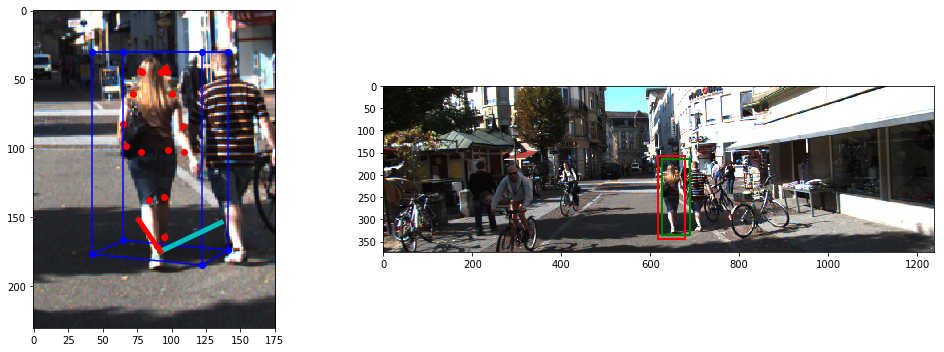

In [48]:
show_3d(pedestrian)